# Homework 4
Samarth Kumar (szk0187)

---

Import dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler

Load and preprocess dataset.

In [5]:
# Load the dataset from UCI ML Repository
wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features
y = wine_quality.data.targets

X = X.to_numpy()
y = y.to_numpy()

# Convert to binary classification (good vs bad wine)
y = np.where(y > 5, 1, 0) 

# Split test/train
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xTest_scaled = scaler.transform(xTest)

### (b) PCA On Normalized Training Set

In [8]:
pca = PCA(n_components=None)
pca.fit(xTrain_scaled)
pca.get_params()

# Determine the number of components needed for PCA, and what original features were important for the first 3 principal components.



{'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [9]:
from sklearn.decomposition import PCA
import numpy as np

# 1. Fit PCA on your scaled training set
pca = PCA().fit(xTrain_scaled)

# 2. How many components to reach 95%?
cum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cum_var >= 0.95) + 1
print(f"{n_components_95} components explain ≥95% of the variance")

# 3. Examine the first three principal components
feature_names = [
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar",
    "chlorides", "free sulfur dioxide", "total sulfur dioxide",
    "density", "pH", "sulphates", "alcohol"
]

for pc_idx in range(3):
    loadings = pca.components_[pc_idx]
    # sort by absolute loading magnitude, descending
    top_idx = np.argsort(np.abs(loadings))[::-1][:3]
    print(f"\nPC{pc_idx+1} (explained variance ratio = {pca.explained_variance_ratio_[pc_idx]:.2%}):")
    for i in top_idx:
        print(f"  {feature_names[i]:<20s} loading = {loadings[i]:+.3f}")


9 components explain ≥95% of the variance

PC1 (explained variance ratio = 27.60%):
  total sulfur dioxide loading = +0.488
  free sulfur dioxide  loading = +0.435
  volatile acidity     loading = -0.377

PC2 (explained variance ratio = 22.65%):
  density              loading = +0.584
  alcohol              loading = -0.464
  residual sugar       loading = +0.338

PC3 (explained variance ratio = 14.21%):
  citric acid          loading = +0.594
  pH                   loading = -0.457
  fixed acidity        loading = +0.431


### (c) Use NMF

C:\Users\skuma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\skuma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\skuma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\skuma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-

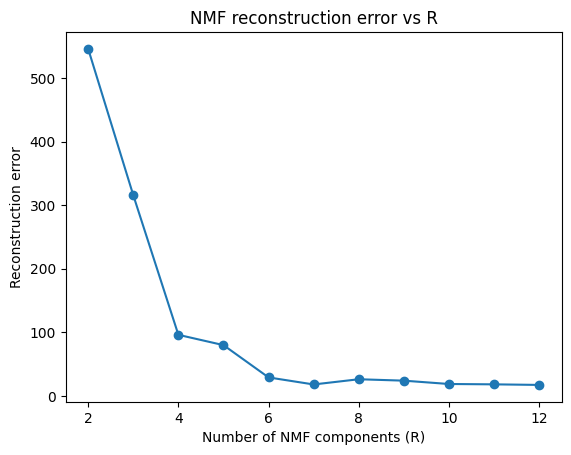

In [11]:
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

errors = []
components = range(2, 13)
for r in components:
    nmf = NMF(n_components=r, init='random', random_state=42, max_iter=500)
    nmf.fit(xTrain)
    errors.append(nmf.reconstruction_err_)

plt.plot(components, errors, marker='o')
plt.xlabel("Number of NMF components (R)")
plt.ylabel("Reconstruction error")
plt.title("NMF reconstruction error vs R")
plt.show()

Using NMF, the R value should be 6. When looking at the graph above, the steepest drop in error happens from R values 2 to 4, and the second steepest drop is from R values 5 to 6. When R > 6, there are only very minimal drops in the error. So I will choose **R = 6**

### (d) Logistic Regression Models

C:\Users\skuma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\skuma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\skuma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\skuma\AppData\Local\Packages\PythonSoftwareFounda

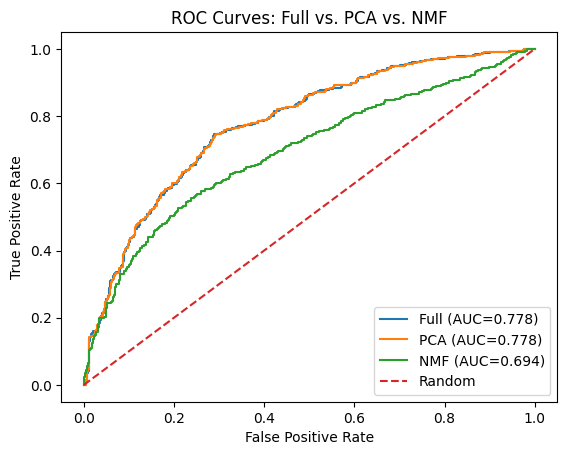

In [13]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

R = 9  # selected from part (c)

# 1) PCA projection
pca = PCA(n_components=R, random_state=42)
Z_train = pca.fit_transform(xTrain_scaled)
Z_test  = pca.transform(xTest_scaled)

# 2) NMF projection
nmf = NMF(n_components=R, init='random', random_state=42, max_iter=500)
W_train = nmf.fit_transform(xTrain)
W_test  = nmf.transform(xTest)

# 3) Define datasets for the three models
datasets = {
    "Full": (xTrain_scaled, xTest_scaled),
    "PCA":  (Z_train,      Z_test),
    "NMF":  (W_train,      W_test),
}

plt.figure()
for name, (X_tr, X_te) in datasets.items():
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_tr, yTrain)
    probs = lr.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(yTest, probs)
    score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={score:.3f})")

# Random‐guess baseline
plt.plot([0, 1], [0, 1], '--', label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Full vs. PCA vs. NMF")
plt.legend()
plt.show()
